In [1]:
from gensim.models import Word2Vec

In [2]:
import os
import json

FILE_PATH = 'data/glassdoor_us/'

def get_body(path):
    return json.load(open(path, 'r'))['body']

data = [get_body(FILE_PATH + file) for file in os.listdir(FILE_PATH)]

N_DOCUMENTS = len(data)
N_DOCUMENTS

955

In [3]:
buzz_words = {}
for raw_line in open('java_buzzwords.txt', 'r'):
    line = raw_line.strip().lower()
    
    # skip empty line or comment
    if len(line) == 0 or line[0] == '#':
        continue
    
    # add synnonyms to dictionary
    tokens = line.split('|')
    label = tokens[0]
    for key in tokens:
        buzz_words[key] = label

In [4]:
from nltk.tokenize import RegexpTokenizer
import random

tokenizer = RegexpTokenizer(r'[\w\-\#\+]+')
buzzword_keys = set(buzz_words.keys())

def replace_ngrams(doc):
    result = doc
    for key, value in buzz_words.items():
        if ' ' in key and key in result:
            result = result.replace(key, value)
            
    return result

def find_buzzwords(doc):
    doc = replace_ngrams(doc)
    result = [buzz_words[token] for token in tokenizer.tokenize(doc.lower()) if token in buzzword_keys]
    return list(set(result))

buzzwords = [find_buzzwords(doc) for doc in data]

augmented = []
frequency = {}

for sent in buzzwords:
    
    for word in sent:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1
    
    for i in range(50):
        s2 = sent.copy()
        random.shuffle(s2)
        augmented.append(s2)
        
random.shuffle(augmented)

In [5]:
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=64,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0001, 
                     negative=20,
                     workers=4)

w2v_model.build_vocab(augmented, progress_per=100)


In [6]:
w2v_model.train(augmented, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

(3317128, 38300000)

In [7]:
w2v_model.corpus_count

47750

In [8]:
w2v_model.init_sims(replace=True)

In [9]:
w2v_model.wv.most_similar(positive=["angular.js"])

[('css', 0.4187140464782715),
 ('spring', 0.3823813498020172),
 ('mobile', 0.36922869086265564),
 ('javascript', 0.34276703000068665),
 ('react.js', 0.33033204078674316),
 ('ant', 0.3179934620857239),
 ('oracle', 0.3179691433906555),
 ('jquery', 0.28544333577156067),
 ('ibatis', 0.2730359435081482),
 ('gulp', 0.25711673498153687)]

In [10]:
from sklearn.manifold import TSNE

coordinates = TSNE(n_components=2).fit_transform(w2v_model.wv.vectors)
coordinates.shape

(177, 2)

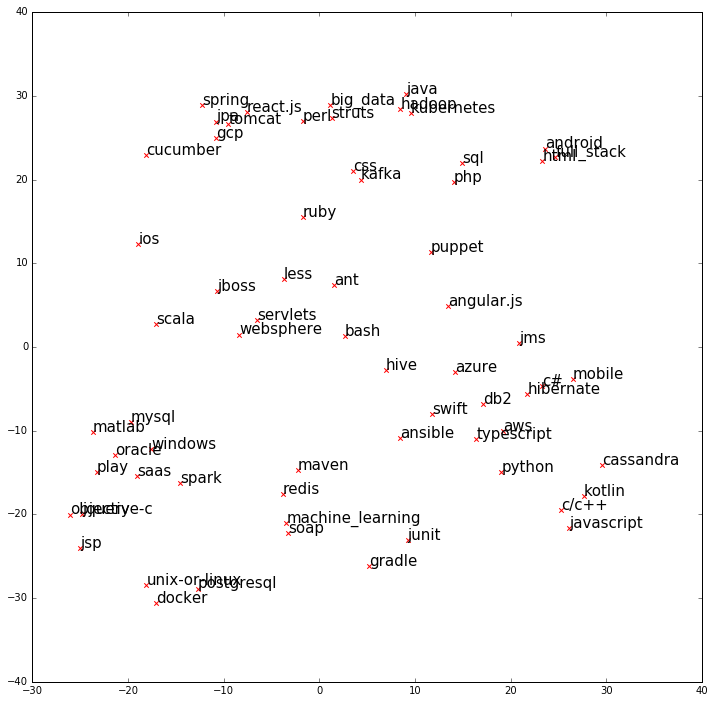

In [11]:
from sklearn.manifold import TSNE

coordinates = TSNE(n_components=2, perplexity=10).fit_transform(w2v_model.wv.vectors)
coordinates.shape


import matplotlib.pyplot as plt
%matplotlib inline

#from matplotlib.pyplot import figure
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

labels = w2v_model.wv.vocab

for i, label in enumerate(labels):
    
    if (frequency[label] / N_DOCUMENTS) < 0.02:
        continue
        
    x = coordinates[:, 0][i]
    y = coordinates[:, 1][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x + 0.01, y + 0.01, label, fontsize=15)
plt.show()

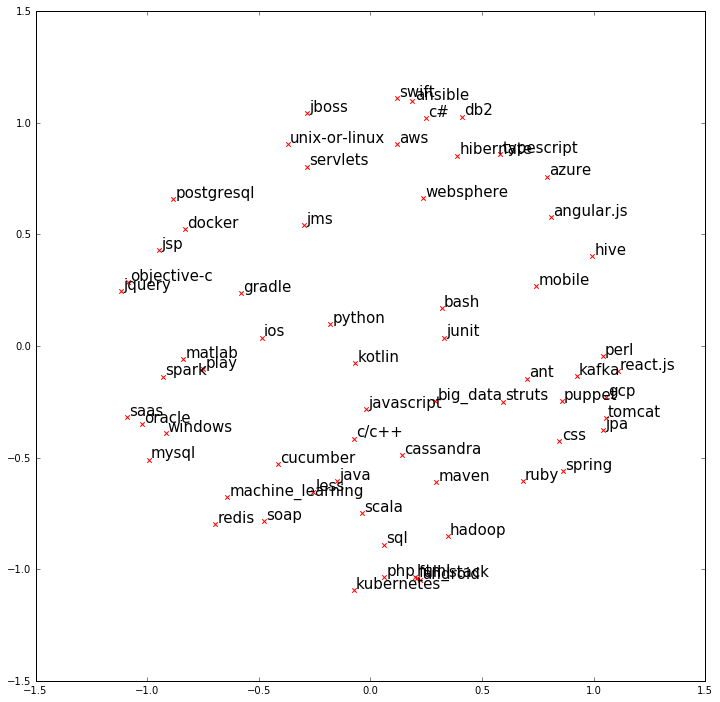

In [12]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, n_init=10, max_iter=500, n_jobs=4)
coordinates_mds = embedding.fit_transform(w2v_model.wv.vectors)
coordinates_mds

import matplotlib.pyplot as plt
%matplotlib inline

#from matplotlib.pyplot import figure
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

labels = w2v_model.wv.vocab

for i, label in enumerate(labels):
    
    if (frequency[label] / N_DOCUMENTS) < 0.02:
        continue
        
    x = coordinates_mds[:, 0][i]
    y = coordinates_mds[:, 1][i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x + 0.01, y + 0.01, label, fontsize=15)
plt.show()